# Markowitz Model
## Modern Portfolio Theory

[Example of Applying Modern Portfolio Theory (MPS)](https://www.investopedia.com/articles/company-insights/083016/example-applying-modern-portfolio-theory-mps.asp)

Key Assumptions of Modern Portfolio Theory:
* Investors attempt to maximize returns given their unique situation
* Asset returns are normally distributed
* Investors are rational and avoid unnecessary risk
* All investors have the same view on expected returns
* Taxes and trading costs are not considered
* Single investors are not sizable enough to influence market prices
* Unlimited amounts of capital can be borrowed at the risk-free rate
  
The Efficient Portfolio is the Portfolio that has the highest reward for a given level of risk or the lowest risk for a given return.

![](Images/efficient_portfolio.png)


In [1]:
import numpy as np
# import yahoo finance to pull stock and crypto data from
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization
# bringing in these libraries in order to use a dynamic date selection - see sub_years
import datetime as dt
import os
import questionary
from pathlib import Path 
import csv
import fire
import requests
from datetime import date
from MCForecastTools import MCSimulation

In [2]:
# stocks we are going to handle

# lets come up with a way for the user to select an asset type (stock or crypto)
# and get the top 5 stocks or top 3 cryptos in order to build a portfolio
# stocks = ['AAPL', 'AMZN', 'GOOG', 'TSLA']


In [3]:
# we want the user to focus on the assets they are wanting to analyze and not the amount of data the program is analyzing
# so in order to get the most relevant information we create a dynamic date range with a rolling 10 year window
# first we create a variable today and set it equal to the datetime libraries date.today() 
today = date.today()

# once we have todays date we can run a formula to replace the year output from the date.today() with whatever timeframe we enter
# in our program we will set this input at 10 years
def sub_years(today_date, years):
    try:
        return today_date.replace(year = today_date.year - years)
    except ValueError:
        return today_date + (date(today_date.year + years, 1, 1) - date(today_date.year, 1, 1))

In [4]:
# historical data - define START and END dates
# to calculate the start_date we must use the sub_years function defined above to get today's date and subtract 10 years
# then using the .strftime('%Y-%m-%d') we format it so that it can be passed to yahoo finance
start_date = sub_years(today, 10).strftime('%Y-%m-%d')
# for the end_date we just have to reformat the today variable with the .strftime('%Y-%m-%d') we format it so that it can be passed to yahoo finance 
end_date = today.strftime('%Y-%m-%d')

### IF WE ARE GOING TO ALLOW CRYPTO THEN WE NEED TO UPDATE THE TRADING DAYS TO 365 AND RERUN THE CALCS

# number of trading days in a year (stocks only)
num_tradings_days_stocks = 252
num_tradings_days_crypto = 365

# set variable of amount of random w (different portfolios) we want to create
num_portfolios = 20000

In [5]:
# define a function download_data()
def download_data(stocks):
    stock_data = yf.download(
        #tickers list or string as well
        tickers = stocks,

        # use "period" instead of start/end
        # valid periods: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
        # (optional, default is "1mo")
        period = "10y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = '1d',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integre)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )['Close']

    return pd.DataFrame(stock_data)


In [6]:
# define a function show_data()
def show_data(data):
    data.plot(figsize=(20,10), grid=True, xlabel='Date', ylabel="Stock Price", title=f"Historical Price from {start_date} through {end_date}")
    plt.show()


In [7]:
# define return
def calculate_log_return(data):
    # NORMALIZATION - to measure all variables in comparable metric
    log_return = np.log(data/data.shift(1))
    # return [1:] takes out the null values from the first data point
    return log_return[1:]

In [8]:
def calculate_return(data):
    daily_returns = data.pct_change()

    return daily_returns[1:]

In [9]:
# define annual metrics
def show_statistics(returns):
    print(returns.mean() * num_tradings_days)
    print(returns.cov() * num_tradings_days)

In [10]:
#
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean()*weights) * num_tradings_days_stocks
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*num_tradings_days_stocks, weights)))
    print(f"Expected portfolio mean (return): {portfolio_return}")
    print(f"Expected portfolio volatilit (standard deviation): {portfolio_volatility}")

In [11]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(num_portfolios):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * num_tradings_days_stocks)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * num_tradings_days_stocks, w))))
    
    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)



In [12]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(20,10))
    plt.scatter(volatilities, returns, c=returns/volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Returns')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [13]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * num_tradings_days_stocks
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * num_tradings_days_stocks, weights)))

    return np.array([portfolio_return, portfolio_volatility, portfolio_return/portfolio_volatility])

In [14]:
# scipy optimize module can find the minimum of a given function
# the maximum of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

In [15]:
# what are the constraints? the sum of weights = 1
# f(x)=0 this is the function to minimize
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    cons = {'type': 'eq', 'fun': lambda x: np.sum(x) -1}
    # the weights can be 1 at most: 1 when 100% of money is invested inot a single stock
    bnds = tuple((0,1) for _ in range(len(stocks)))
    
    return optimization.minimize(
                fun=min_function_sharpe,
                x0=weights[0],
                args=returns,
                method='SLSQP',
                bounds=bnds,
                constraints=cons
                )

In [16]:
# print the Stocks and Weights into a manageable pd.DataFrame to be easier to read and export
def print_optimal_portfolio_dataframe(optimum, returns):
    # first create a variable to be passed into the new dataframe
    weights = optimum['x']
    # create the new dataframe with index = stocks
    optimal_portfolio_weights_df = pd.DataFrame({'Weights %': weights}, index=stocks)
    
    # create another dataframe that holds the metrics we are tracking for our portfolio
    headers = ['Expected Returns', 'Expected Volatility', 'Expected Sharpe Ratio']
    stats = statistics(optimum['x'].round(3), returns)
    metrics = pd.DataFrame({"Metrics": stats}, index=headers)
    
    print(metrics)
    # the weights are ordered in the same order as the stocks from above so they will print side by side
    print(optimal_portfolio_weights_df)

In [17]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(20,10))
    plt.style.use(['dark_background'])
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets/portfolio_vols, marker='o')
    plt.grid(True)
    plt.rcParams.update({'font.size': 18})
    plt.title(f"Modern Portfolio Theory for {stocks}")
    plt.xlabel("Expected Volatility")
    plt.ylabel("Expected Return")
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'r*', markersize=20.0)

In [18]:
def clean_df_monte_carlo(dataset, daily_returns):
    # bring in dataset and add multiindex column name 'close'
    dataset.columns = pd.MultiIndex.from_product([dataset.columns, ['close']])

    # bring in log_daily_returns and add multiindex column name 'daily_returns'
    daily_returns.columns = pd.MultiIndex.from_product([daily_returns.columns, ['daily_return']])

    # join the 2 tables together
    joined_df_columns = pd.concat(
        [dataset, daily_returns],
        axis='columns',
        join='inner'
    )

    # sort the columns by ticker symbol
    joined_df_columns.sort_index(axis=1, level=0, inplace=True)

    return pd.DataFrame(joined_df_columns)


In [19]:
def monte_carlo(dataset, optimum, investment):
    num_trading_days = 252
    # Configure the Monte Carlo simulation to forecast 30 years cumulative returns
    # The weights should be split 40% to AGG and 60% to SPY.
    # Run 500 samples.
    weights = optimum['x']

    optimal_portfolio_weights_df = pd.DataFrame({'Weights %': weights}, index=stocks)
    # dataset.columns = pd.MultiIndex.from_product([['close'], dataset.columns])

    MC_Stocks = MCSimulation(
        portfolio_data= dataset, 
        weights=weights,
        num_simulation=500,
        num_trading_days=num_trading_days
    )

    # Review the simulation input data
    MC_Stocks.calc_cumulative_return()

    mc_stock_tbl = MC_Stocks.summarize_cumulative_return()
    
    print(mc_stock_tbl)

    mc_ci_lower = round(mc_stock_tbl[8]*investment,2)
    mc_ci_upper = round(mc_stock_tbl[9]*investment,2)

    print(f"There is a 95% chance that an initial investment of ${investment} in the portfolio"
      f" over the next {round(num_trading_days / 252)} years will end within in the range of"
      f" ${mc_ci_lower} ({round(((mc_ci_lower - investment) / investment) * 100,2)}%) and ${mc_ci_upper} ({round(((mc_ci_upper - investment) / investment) * 100,2)}%).")

    return MC_Stocks


In [20]:
# in order to get both plots to show we had to create a separate function for each plot
# and pass the MC_Stocks dataframe in as a parameter
# ultimately we had to use "plt.show()" in order for the plots to populate individually
def mc_line_plot(MC_Stocks):
    MC_Stocks.plot_simulation()
    plt.show()

# mc_line_plot(MC_Stocks)

In [21]:
# in order to get both plots to show we had to create a separate function for each plot
# and pass the MC_Stocks dataframe in as a parameter
# ultimately we had to use "plt.show()" in order for the plots to populate individually
def mc_dist_plot(MC_Stocks):
    MC_Stocks.plot_distribution()
    plt.show()

# mc_dist_plot(MC_Stocks)

[*********************100%***********************]  4 of 4 completed
                        Metrics
Expected Returns       0.309422
Expected Volatility    0.254932
Expected Sharpe Ratio  1.213743
      Weights %
AAPL   0.287699
AMZN   0.257698
GOOG   0.246690
TSLA   0.207912


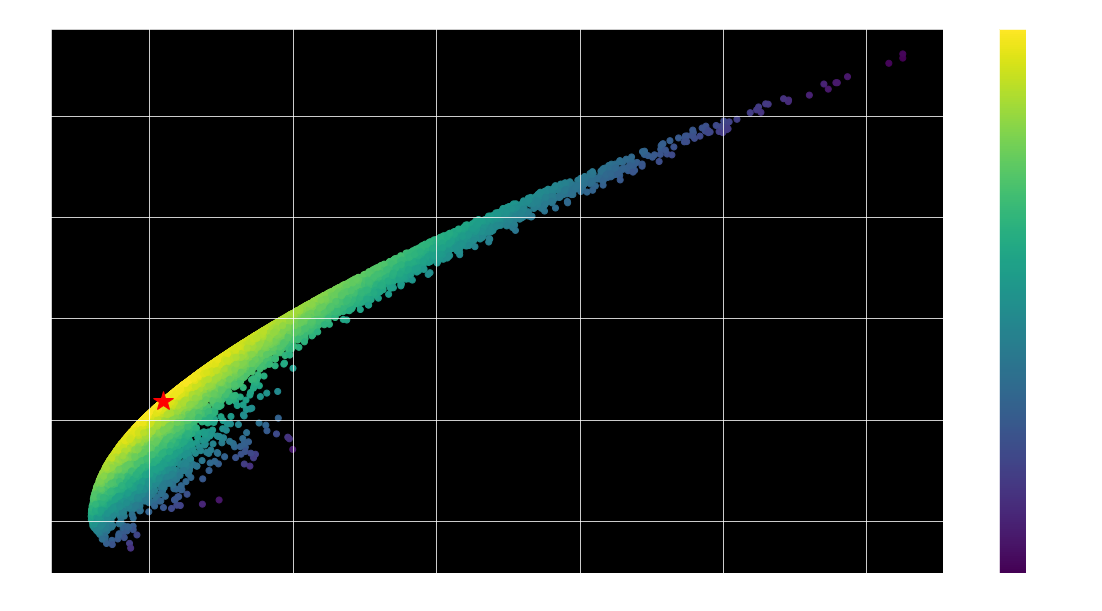

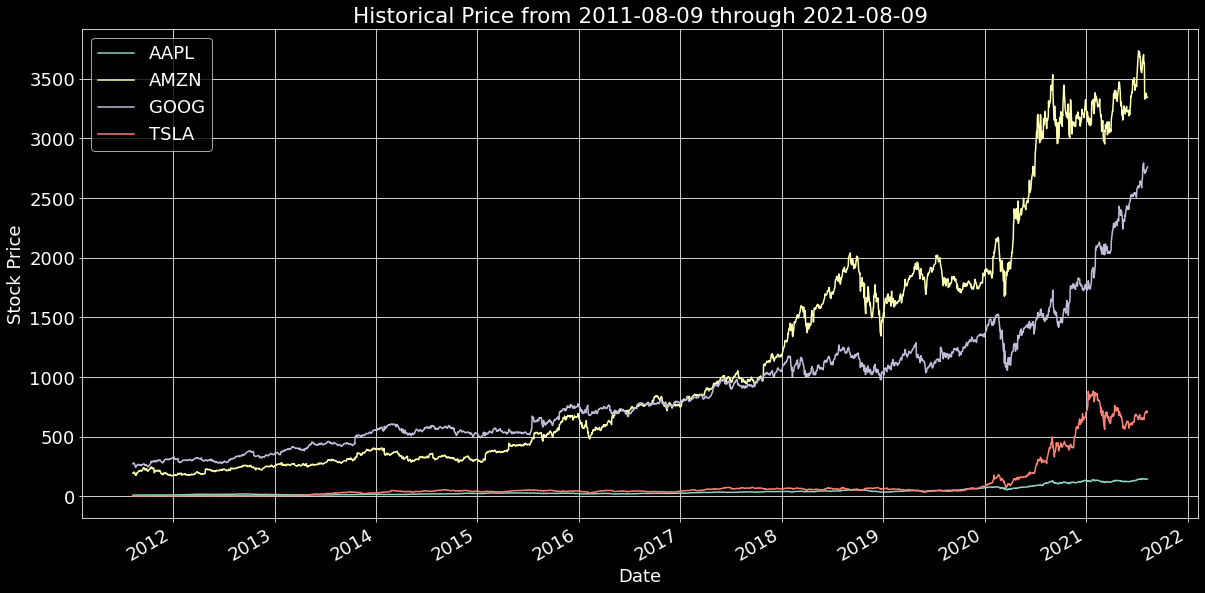

c:\Users\sslusher\Desktop\FinTech_Workspace\Project_1\Portfolio-Builder\workflow\MCForecastTools.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if weights == "":


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 400.
count           500.000000
mean              1.456921
std               0.259318
min               0.917304
25%               1.271917
50%               1.428286
75%               1.609539
max               2.490034
95% CI Lower      1.043202
95% CI Upper      2.026647
Name: 252, dtype: float64
There is a 95% chance that an initial investment of $20000 in the portfolio over the next 1 years will end within in the range of $20864.05 (4.32%) and $40532.93 (102.66%).


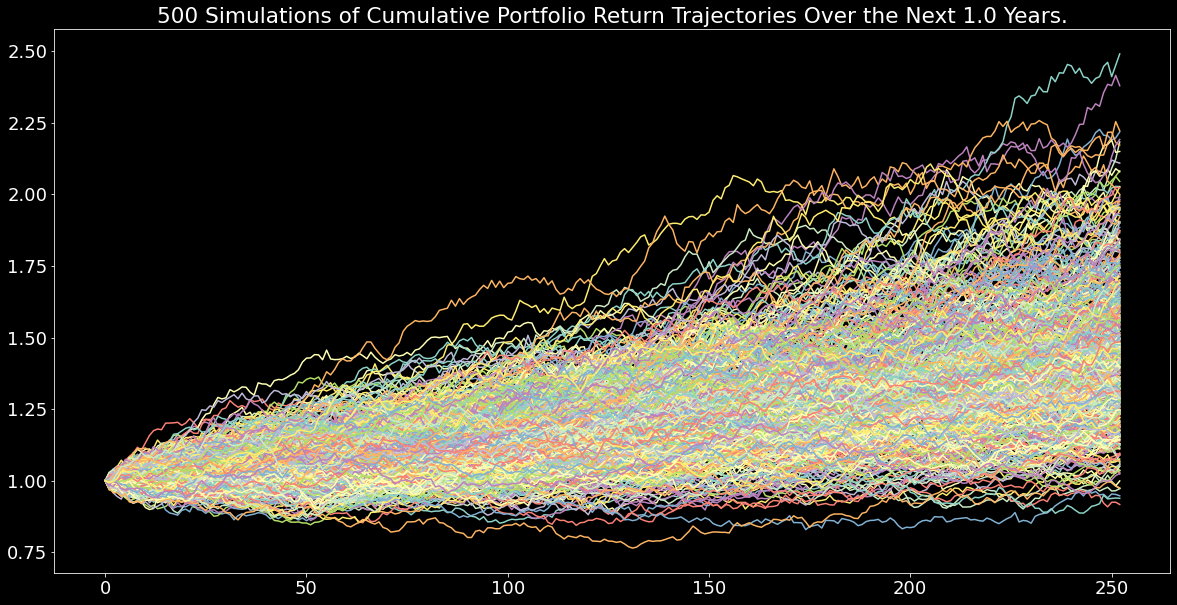

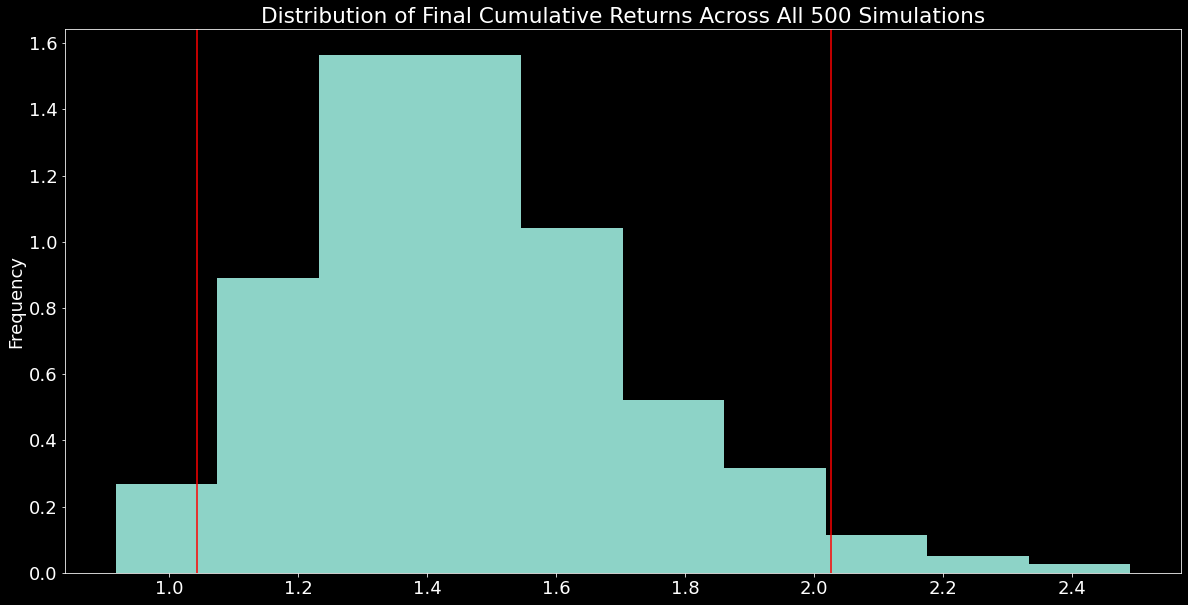

In [22]:
if __name__ == '__main__':
    # this is a parameter passed from questionary
    investment = 20000

    # these are variables selected by user and passed to the "download_data()" function
    stocks = ['AAPL', 'AMZN', 'GOOG', 'TSLA']

    # download_data() returns a dataframe called "dataset" that will be passed to the following functions:
    # calculate_log_return(), show_data(), calculate_return(), clean_df_monte_carlo()
    dataset = download_data(stocks)
    
    # calculate_log_return() takes the dataset variable and creates the log returns to the following functions:
    # generate_portfolio(), optimize_portfolio(), print_optimal_portfolio_dataframe(), show_optimal_portfolio()
    # calculate_log_return() is used to NORMALIZE the dataset
    log_daily_returns = calculate_log_return(dataset)

    # generate_portfolio() takes the log_daily_returns variable created by the calculate_log_return() function
    # from this function it will create the following lists as variables to be passed to further functions:
    # Variables : portfolio_weights, means, risk
    # passed to optimize_portfolio(), show_optimal_portfolio()
    portfolio_weights, means, risks = generate_portfolios(log_daily_returns)

    # optimize_portfolio() takes the portfolio_weights variable from generate_portfolios() 
    # and the log_daily_returns from calculate_log_return()
    # this function will return a variable named "optimum" which are the optimum weights for the selected stocks
    # this variable will be passed to the following down range functions:
    # show_optimal_portfolio(), monte_carlo()
    optimum = optimize_portfolio(portfolio_weights, log_daily_returns)

    # this function prints the metrics and weights of the portfolio for better clarity
    print_optimal_portfolio_dataframe(optimum, log_daily_returns)

    # this function graphs the simulation to generate the optimum weights and places a red star on the weights selected
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)

    # this function returns a graph of historical price action based on 10 years of data
    show_data(dataset)

    # calculate_return() take the dataset as a parameter to calculate the standard returns to pass to the cleaned_df_monte_carlo()
    daily_return = calculate_return(dataset)

    # clean_df_monte_carlo() takes 2 dataframes (dataset, daily_returns) and combines them together to be passed to the monte_carlo()
    clean_df_monte_carlo = clean_df_monte_carlo(dataset, daily_return)

    # monte_carlo() runs the simulation to project the 95% confidence level of the value of the portfolio based on weight allocations
    # it returns a variable of MC_Stocks to pass to the plot functions down range
    MC_Stocks = monte_carlo(clean_df_monte_carlo, optimum, investment)

    # this plots the monte_carlo() simulation
    mc_line_plot(MC_Stocks)

    # this plots the 95% confidence levels of the monte_carlo()
    mc_dist_plot(MC_Stocks)



